# Pipeline:


### -Lectura del Dataset original. [path dataset Original]

### -Agregar Features [numero de features mas representativos a incluir]
### -Agregar Clasificacion [valores para separar]

# Notebook donde agrega el SUFFLE para validar que aprende el algoritmo

In [9]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import os, glob
import random

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget
import os, glob


from matplotlib import pyplot
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
#plots
import seaborn as sns

from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


from backtesting import Backtest, Strategy
from backtesting.lib import crossover, SignalStrategy, TrailingStrategy, resample_apply
from backtesting.test import SMA
from backtesting import Backtest
#plots
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd 
import math as m
import os, glob

In [10]:
MODEL_NAME = "XGBoost_5"
FRECUENCIA = "4H"
INDEX_TO_READ = 5
LIMITE_IZQ = [-.002] #-0.0025, -.002, -.0018] #[-.002]#[-0.0029, -0.0025, -.002]
LIMITE_DER = [.0025] # 0.0025, .002, .0018] #[.0025]#[0.0029, 0.0025, .002]

CICLOS = 100
BALANCED = False
WITH_SUFFLE = True
IDX_TEST_START = 0
TARGET_NAME = "Class"
PROFUNDIDAD = [0] #[0,1,2,3,4,5,6,7,8,9,10] #[1,2] #[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]

VAL_PCT = [.25]#[.2, .25]
TEST_PCT = [.2]#[.2, .15]


CASH = 1000
COMMISSION = 0.0001

In [11]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados-regression/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(filenames.index(file), ' ', os.path.basename(file))

0   R-EURUSD_FULL_1D_144F.csv
1   R-EURUSD_FULL_1D_44F.csv
2   R-EURUSD_FULL_1D_69F.csv
3   R-EURUSD_FULL_1H_44F.csv
4   R-EURUSD_FULL_1H_49F.csv
5   R-EURUSD_FULL_4H_144F.csv


In [12]:
def read_dataset(INDEX_TO_READ):
    if FRECUENCIA =="1D":
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    else:
        dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    DATASET_FULL = pd.read_csv(filenames[INDEX_TO_READ], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
    #print(DATASET_FULL)
    #print(DATASET_FULL.shape)
    return DATASET_FULL
    
def add_target_column(DATASET_FULL, limite_izq, limite_der):
    DATASET_FULL['Class'] = 0

    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] <= limite_izq, 'Class'] = -1
    DATASET_FULL.loc[DATASET_FULL['Pct_Range_Close'] >= limite_der, 'Class'] = 1

    DATASET_FULL['Class'] = DATASET_FULL['Class'].shift(-1)
    DATASET_FULL['Class'].fillna(0, inplace=True)
    #print(DATASET_FULL['Class'].head(5))
    return DATASET_FULL


def remove_features(data):
    data = data.drop(['Gmt time'], axis = 1)
    data = data.drop(['day_name'], axis = 1)
    data = data.drop(['weekday'], axis = 1)
    data = data.drop(['Open_Bid'], axis = 1)
    data = data.drop(['High_Bid'], axis = 1)
    data = data.drop(['Low_Bid'], axis = 1)
    data = data.drop(['Close_Bid'], axis = 1)
    return data

def get_target_vector(data):
    labels = data['Class'].values
    data = data.drop(columns=['Class'])
    return data, labels

def get_2Dimension(df, PROFUNDIDAD):
    new_df = pd.DataFrame()
    for i in range(PROFUNDIDAD):
        for j in range (df.shape[1]):
            new_col_name = df.columns[j] + '_' + str(i+1)
            new_df[new_col_name] = df.iloc[i+1:,j]
            new_df.fillna(method='backfill', inplace=True)
    #print(new_df.columns)
    df = pd.concat([df, new_df], axis=1, sort=False)
    df.fillna(method='backfill', inplace=True)
    return df

def split_in_3(data, y_vector, val_pct, test_pct):
    total = data.shape[0]
    #print('Total: ', total)

    s1 = test_pct + val_pct
    #print('Sum of %s:',s1)
    f1 = int(total * s1)
    #print('count of Val and Test:',f1)
    end_train = total - f1
    #print('end of train: ', end_train)

    count_val= int(total * val_pct)
    #print('count val: ',count_val)

    count_test= int(total * test_pct)
    #print('count test: ',count_test)

    end_val = end_train + count_val
    #print('end_val', end_val)

    x_train = data.iloc[:end_train]
    x_val = data.iloc[end_train: end_val]
    x_val.reset_index(drop=True, inplace=True)
    x_test = data.iloc[end_val:]
    IDX_TEST_START = end_val
    x_test.reset_index(drop=True, inplace=True)

    #print("x_train.shape: ",x_train.shape)
    #print("x_val.shape: ", x_val.shape)
    #print("x_test.shape: ", x_test.shape)

    y_train = y_vector[:end_train]
    y_val = y_vector[end_train: end_val]
    y_test = y_vector[end_val:]

    #print("y_train.shape: ", y_train.shape)
    #print("y_val.shape: ", y_val.shape)
    #print("y_test.shape: ", y_test.shape)

    
    return x_train, x_val, x_test, y_train, y_val, y_test


def split_in_3_with_suffle(data, y_vector, val_pct, test_pct, PROFUNDIDAD):
    total = data.shape[0]
    #print('Total: ', total)

    s1 = test_pct + val_pct
    #print('Sum of %s:',s1)
    f1 = int(total * s1)
    #print('count of Val and Test:',f1)
    end_train = total - f1
    #print('end of train: ', end_train)

    count_val= int(total * val_pct)
    #print('count val: ',count_val)

    count_test= int(total * test_pct)
    #print('count test: ',count_test)

    end_val = end_train + count_val
    #print('end_val', end_val)

    start_val = total - count_val + PROFUNDIDAD
    #print('start_val ', start_val)
    
    #inicial el random
    random.seed()
    #print('hasta: ', total-count_test-count_val)
    slice_random_x_test_at = random.randint(20, total-count_test-count_val)
    print('x_test indice start at: ', slice_random_x_test_at)
    
    end_x_train_first_block = slice_random_x_test_at - PROFUNDIDAD
    #print('end_x_train_first_block: ',end_x_train_first_block)
    x_train_first_block = data.iloc[:end_x_train_first_block]
    
    start_second = slice_random_x_test_at + count_test + PROFUNDIDAD
    #print('start_second ', start_second)

    #print('end_second_train ', start_val)
    x_train_second_block = data.iloc[start_second:start_val-6]
    
    x_train = pd.concat([x_train_first_block, x_train_second_block], sort=False)
    x_train.reset_index(drop=True, inplace=True)
    #print('shape x_train: ',x_train.shape)
    x_val = data.iloc[start_val:]
    x_val.reset_index(drop=True, inplace=True)
    #print('shape x_val: ',x_val.shape)
    x_test = data.iloc[slice_random_x_test_at:slice_random_x_test_at+count_test]
    x_test.reset_index(drop=True, inplace=True)
    #print('shape x_test: ',x_test.shape)
    #print("x_train.shape: ",x_train.shape)
    #print("x_val.shape: ", x_val.shape)
    #print("x_test.shape: ", x_test.shape)

    
    y_train_first_block = y_vector[:end_x_train_first_block]
    y_train_second_block = y_vector[start_second:start_val-6]
    
    y_train = np.concatenate((y_train_first_block, y_train_second_block), axis=0)    
    #print('shape y_train: ',y_train.shape)
    y_val = y_vector[start_val:]
    #print('shape y_val: ',y_val.shape)
    y_test = y_vector[slice_random_x_test_at:slice_random_x_test_at+count_test]
    #print('shape y_test: ',y_test.shape)
    #print("y_train.shape: ", y_train.shape)
    #print("y_val.shape: ", y_val.shape)
    #print("y_test.shape: ", y_test.shape)

    
    return x_train, x_val, x_test, y_train, y_val, y_test, slice_random_x_test_at

def get_train_resampling(x_train, y_train):
    target = pd.DataFrame(y_train, columns = ["target"])
    x_train_target  = pd.concat([x_train, target], axis=1, sort=False)
    x_train_target['target'].value_counts()

    match_majority = x_train_target['target'].value_counts()[0]
    match_majority

    # resample for sell
    df_majority_sell = x_train_target[x_train_target.target != -1]
    df_minority_sell = x_train_target[x_train_target.target == -1]
    df_minority_sell_upsampled = resample(df_minority_sell, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled_sell = pd.concat([df_majority_sell, df_minority_sell_upsampled])
    df_upsampled_sell['target'].value_counts()


    #resample for buy
    df_majority_buy = df_upsampled_sell[df_upsampled_sell.target != 1]
    df_minority_buy = df_upsampled_sell[df_upsampled_sell.target == 1]
    df_minority_buy_upsampled = resample(df_minority_buy, 
                                     replace=True,     # sample with replacement
                                     n_samples=match_majority,  # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled  = pd.concat([df_majority_buy, df_minority_buy_upsampled])
    df_upsampled['target'].value_counts()
    labels = df_upsampled['target'].values
    df_upsampled = df_upsampled.drop(['target'], axis = 1)
    return df_upsampled, labels


def train_xgboost_model(x_train, y_train):
    # Train the model, this will take a few minutes to run
    bst = xgb.XGBClassifier(
        objective='reg:logistic'
    )

    bst.fit(x_train, y_train)
    return bst

def get_predictions(model, x_subset):
    predictions = model.predict(x_subset)
    return predictions

def get_acc(predicted, y_subset):
    acc = accuracy_score(y_subset, predicted.round())
    #print(acc, '\n')
    return acc

def print_confision_matrix(y_test, y_pred):
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred.round())
    cm = cm / cm.astype(np.float).sum(axis=1)
    print(cm)
    
def get_dataset_with_pred(dataset_x, vec_y, vec_y_pred):
    y_df = pd.DataFrame({'Real_Class': vec_y})
    y_pred_df = pd.DataFrame({'Predicted_Class': vec_y_pred})
    #print('y_df ',y_df.shape)
    #print('y_pred_df ',y_pred_df.shape)
    dataset_x_vec_y = pd.concat([dataset_x,y_df], axis=1, sort=False)
    #print('dataset_x_vec_y ',dataset_x_vec_y.shape)
    dataset_x_vec_y_pred = pd.concat([dataset_x_vec_y,y_pred_df], axis=1, sort=False)
    #print('x_test ', dataset_x_vec_y_pred.shape)
    return dataset_x_vec_y_pred

def get_filepath_results():
    filename = 'BackTesting_Results_shuffle.csv'
    #print(filename)
    pwd = os.getcwd()
    path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/')
    filename_path_backstesting = os.path.join(pwd, r'../../../Results/pipeline/' + filename)
    #print(filename_path_backstesting)
    return filename_path_backstesting

def backtest(full_test):
    STRATEGY_NAME = limits_Pred
    bt = Backtest(full_test, STRATEGY_NAME, cash=CASH, commission=COMMISSION)#trade_on_close=False
    bt.run()
    return bt._results

In [13]:
class limits_Pred(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Predicted_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [14]:
class limits_Real(SignalStrategy, TrailingStrategy):
    buy_lim = 0.99
    sell_lim = -0.99
    
    def init(self):
        super().init()
        self.Op_Abierta = False
        
    def next(self):
        sig = self.data.Real_Class[-1]
        if not self.Op_Abierta and sig >= self.buy_lim:
            self.buy()
            self.Op_Abierta = True
        if self.Op_Abierta and sig <= self.sell_lim:
            self.sell()
            self.Op_Abierta = False

In [15]:
def pipeline_one(LIMITE_IZQ_one, LIMITE_DER_one, VAL_PCT_one, TEST_PCT_one,  PROFUNDIDAD_one):
    Dataset =  read_dataset(INDEX_TO_READ)
    Dataset_with_target = add_target_column(Dataset, LIMITE_IZQ_one, LIMITE_DER_one)
    Dataset_remove_features = remove_features(Dataset_with_target)

    SIZE = Dataset_remove_features.shape[0]
    NUM_FEATURES = Dataset_remove_features.shape[1]

    Data_without_target, Data_target = get_target_vector(Dataset_remove_features)

    Dataset_in_2d =  get_2Dimension(Data_without_target, PROFUNDIDAD_one)

    if (WITH_SUFFLE):
        x_train, x_val, x_test, y_train, y_val, y_test, IDX_TEST_START = split_in_3_with_suffle(Dataset_in_2d, Data_target, VAL_PCT[0], TEST_PCT[0], PROFUNDIDAD[0])
    else:
        x_train, x_val, x_test, y_train, y_val, y_test = split_in_3(Dataset_in_2d, Data_target, VAL_PCT_one, TEST_PCT_one)
    #Resample Balance 
    if (BALANCED):
        x_train, y_train = get_train_resampling(x_train, y_train)
    
    #Shuffle x_train 
    
    model = train_xgboost_model(x_train, y_train)


    test_predictions =  get_predictions(model, x_test)
    ACC_TEST = get_acc (test_predictions, y_test)
    #print_confision_matrix(y_test, test_predictions)

    val_predictions =  get_predictions(model, x_val)
    ACC_VAL = get_acc (val_predictions, y_val)
    #print_confision_matrix(y_val, val_predictions)

    full_test =  get_dataset_with_pred(x_test, y_test, test_predictions)
    full_val =  get_dataset_with_pred(x_val, y_val, val_predictions)
    filepath_results = get_filepath_results()
    bt_pred = backtest(full_test)

    data_results = {'Model_Name':[MODEL_NAME], 
                    'FRECUENCIA':[FRECUENCIA], 
                    'LIMITE_IZQ':[LIMITE_IZQ_one], 
                    'LIMITE_DER':[LIMITE_DER_one],
                    'PROFUNDIDAD':[PROFUNDIDAD_one],
                    'BALANCED':[BALANCED],
                    'TEST_AT_SUFFLE':[WITH_SUFFLE],
                    'IDX_TEST_START':[IDX_TEST_START],
                    'VAL_PCT':[VAL_PCT_one], 
                    'TEST_PCT':[TEST_PCT_one], 
                    'ACC_TEST':[ACC_TEST],
                    'ACC_VAL':[ACC_VAL],
                    'Duration':[bt_pred['Duration']],
                    'Exposure':[bt_pred['Exposure [%]']],
                    'Buy & Hold Return [%]':[bt_pred['Buy & Hold Return [%]']],
                    '_strategy':[bt_pred['_strategy']],                
                    'Pred_Equity_Final_$':[bt_pred['Equity Final [$]']], 
                    'Pred_Equity_Peak_$':[bt_pred['Equity Peak [$]']], 
                    'Pred_Return_%':[bt_pred['Return [%]']], 
                    'Pred_#_Trades':[bt_pred['# Trades']], 
                    'Pred_Win_Rate':[bt_pred['Win Rate [%]']],
                    'Commission':[COMMISSION],
                    'Cash':[CASH]}
    Results = pd.DataFrame(data_results)
    print('Equity Final [$]: ',bt_pred['Equity Final [$]'])

    Results_loaded = pd.read_csv(filepath_results, header=0)
    Results_loaded = Results_loaded.append(Results,ignore_index=True)

    Results_loaded.to_csv(filepath_results, header=True, index=False)
    return Results_loaded

In [16]:
for m in range(CICLOS):
    print('Ciclo ', m)
    for k in range(len(LIMITE_IZQ)):
        lim_izq = LIMITE_IZQ[k]
        print('   LIMITE_IZQ: ', lim_izq)
        for o in range(len(LIMITE_DER)):
            lim_der = LIMITE_DER[o]
            print('   LIMITE_DER: ', lim_der)
            for i in range(len(PROFUNDIDAD)):
                prof_one = PROFUNDIDAD[i]
                print('      PROFUNDIDAD: ', prof_one)
                for j in range(len(VAL_PCT)):
                    val_pct_one = VAL_PCT[j]
                    print('         VAL_PCT: ', val_pct_one)
                    for jj in range(len(TEST_PCT)):
                        test_pct_one = TEST_PCT[jj]
                        print('            TEST_PCT: ', test_pct_one)
                        pipeline_one(lim_izq, lim_der, val_pct_one, test_pct_one, prof_one)

Ciclo  0
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  7625
Equity Final [$]:  1138.2863181467833
Ciclo  1
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  9503
Equity Final [$]:  746.7929204546302
Ciclo  2
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  14437
Equity Final [$]:  1392.4666930716971
Ciclo  3
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  4783
Equity Final [$]:  1202.9461582582858
Ciclo  4
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  14088
Equity Final [$]:  1026.816568798451
Ciclo  5
   LIMITE_I

Equity Final [$]:  1525.229774063668
Ciclo  42
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  14273
Equity Final [$]:  1316.100683862629
Ciclo  43
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  4768
Equity Final [$]:  796.4109526218919
Ciclo  44
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  5600
Equity Final [$]:  1176.9267144937635
Ciclo  45
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  2761
Equity Final [$]:  800.9781467012959
Ciclo  46
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  8107
Equity Final [$]: 

x_test indice start at:  3612
Equity Final [$]:  778.9687434198709
Ciclo  84
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  9579
Equity Final [$]:  862.9063314396228
Ciclo  85
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  694
Equity Final [$]:  1049.0690439460427
Ciclo  86
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  10422
Equity Final [$]:  978.1218185443556
Ciclo  87
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice start at:  13968
Equity Final [$]:  991.9977570778036
Ciclo  88
   LIMITE_IZQ:  -0.002
   LIMITE_DER:  0.0025
      PROFUNDIDAD:  0
         VAL_PCT:  0.25
            TEST_PCT:  0.2
x_test indice star

In [17]:
filepath_results = get_filepath_results()
Results_loaded = pd.read_csv(filepath_results, header=0)
this_model = Results_loaded.loc[Results_loaded['Model_Name'] == MODEL_NAME]
this_model

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,TEST_AT_SUFFLE,IDX_TEST_START,VAL_PCT,TEST_PCT,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
101,XGBoost_5,4H,-0.002,0.0025,0,False,True,7625,0.25,0.2,...,99.018312,8.881914,limits_Pred,1138.286318,1195.745820,13.828632,77.0,58.441558,0.0001,1000
102,XGBoost_5,4H,-0.002,0.0025,0,False,True,9503,0.25,0.2,...,86.029828,12.439693,limits_Pred,746.792920,1013.393721,-25.320708,52.0,53.846154,0.0001,1000
103,XGBoost_5,4H,-0.002,0.0025,0,False,True,14437,0.25,0.2,...,84.859354,14.075563,limits_Pred,1392.466693,1404.702279,39.246669,14.0,57.142857,0.0001,1000
104,XGBoost_5,4H,-0.002,0.0025,0,False,True,4783,0.25,0.2,...,76.439494,1.644855,limits_Pred,1202.946158,1257.343100,20.294616,113.0,57.522124,0.0001,1000
105,XGBoost_5,4H,-0.002,0.0025,0,False,True,14088,0.25,0.2,...,97.715688,17.093137,limits_Pred,1026.816569,1090.636216,2.681657,43.0,58.139535,0.0001,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,XGBoost_5,4H,-0.002,0.0025,0,False,True,3874,0.25,0.2,...,81.574476,11.313883,limits_Pred,957.362458,1149.562830,-4.263754,71.0,53.521127,0.0001,1000
197,XGBoost_5,4H,-0.002,0.0025,0,False,True,922,0.25,0.2,...,83.028129,20.193720,limits_Pred,1136.454283,1138.926320,13.645428,16.0,31.250000,0.0001,1000
198,XGBoost_5,4H,-0.002,0.0025,0,False,True,8323,0.25,0.2,...,98.867283,3.072846,limits_Pred,1120.427652,1177.190745,12.042765,83.0,59.036145,0.0001,1000
199,XGBoost_5,4H,-0.002,0.0025,0,False,True,13951,0.25,0.2,...,80.573910,13.807187,limits_Pred,1082.825120,1202.642838,8.282512,28.0,60.714286,0.0001,1000


In [18]:
this_model['Pred_Return_%'].describe()

count    100.000000
mean       2.582970
std       18.534814
min      -38.992932
25%      -12.623586
50%        2.158599
75%       13.106818
max       58.654386
Name: Pred_Return_%, dtype: float64

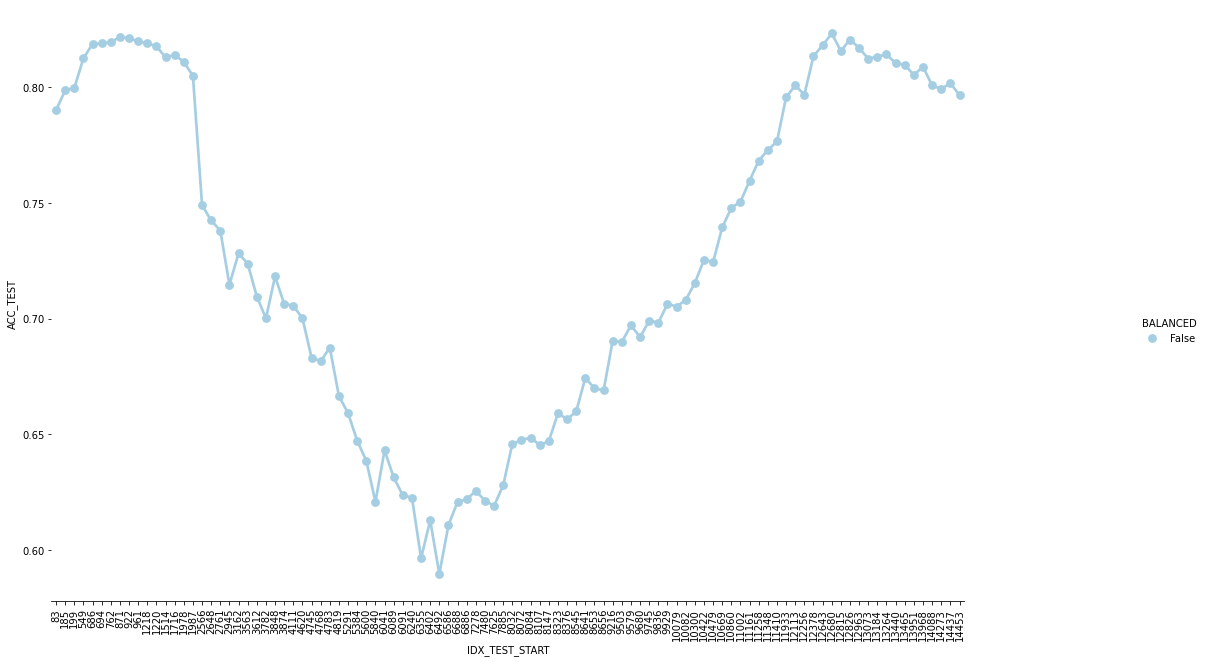

In [19]:
# Draw a pointplot to show pulse as a function of three categorical factors


g = sns.catplot(x="IDX_TEST_START", y="ACC_TEST", hue="BALANCED",# col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.fig.set_figwidth(19.27)
g.fig.set_figheight(9.7)
g.despine(left=True)

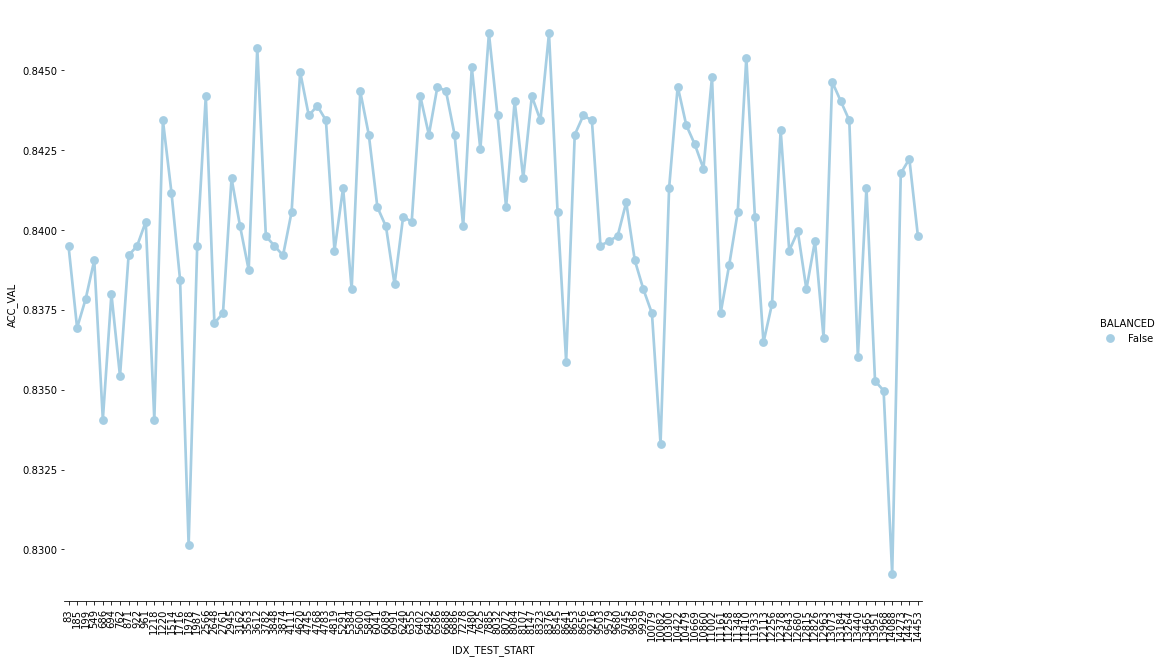

In [20]:
# Draw a pointplot to show pulse as a function of three categorical factors


g = sns.catplot(x="IDX_TEST_START", y="ACC_VAL", hue="BALANCED",# col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.fig.set_figwidth(19.27)
g.fig.set_figheight(9.7)
g.despine(left=True)

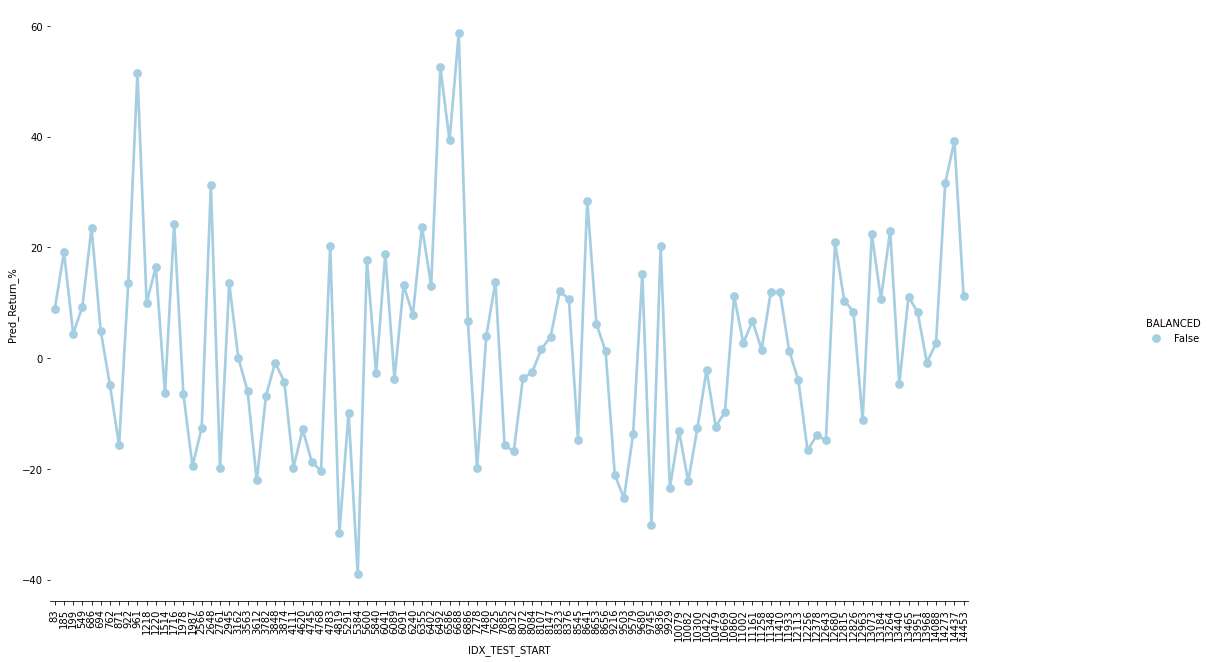

In [21]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="IDX_TEST_START", y="Pred_Return_%", hue="BALANCED", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.fig.set_figwidth(19.27)
g.fig.set_figheight(9.7)
g.despine(left=True)

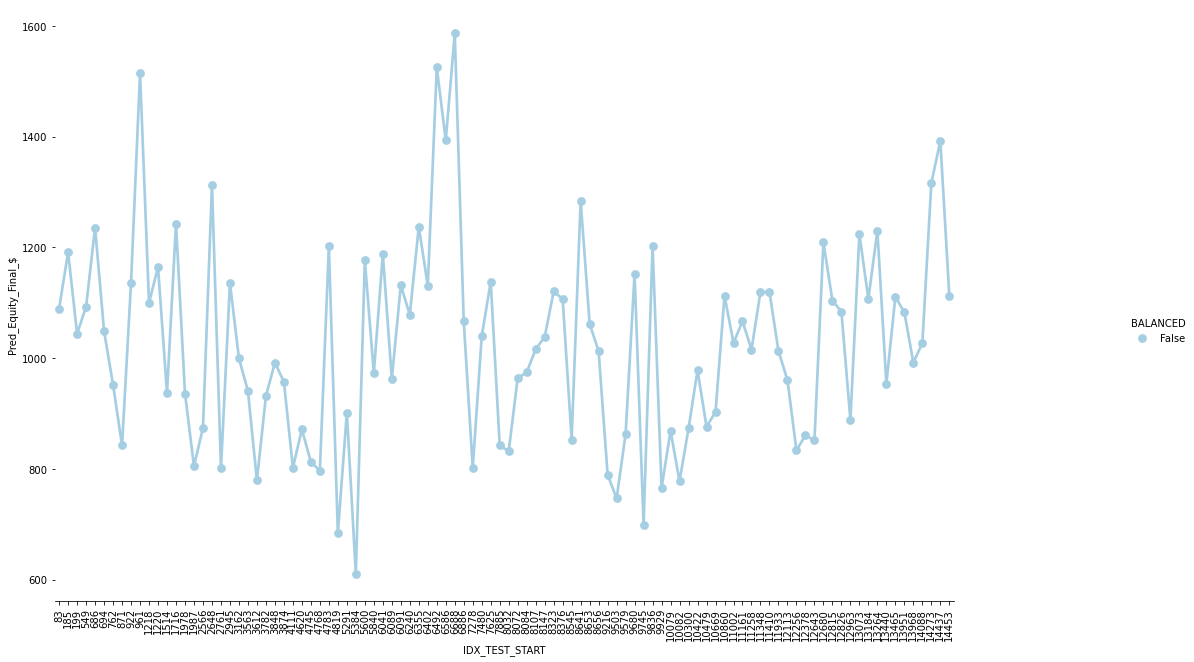

In [22]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="IDX_TEST_START", y="Pred_Equity_Final_$", hue="BALANCED", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="point", data=this_model)
g.set_xticklabels(rotation=90)
g.fig.set_figwidth(19.27)
g.fig.set_figheight(9.7)
g.despine(left=True)

## Aqui se observa como con un subset de validacion de .25 PCT es mejor que con uno de .20 pct. 

## Ademas se observa que los resultados son mejores si se usa una profundidad de 1 a 10, en comparacion de profundidades mayores a 10-24

In [23]:
winners = this_model.loc[this_model['Pred_Return_%'] >= 0]
winners

,Model_Name,FRECUENCIA,LIMITE_IZQ,LIMITE_DER,PROFUNDIDAD,BALANCED,TEST_AT_SUFFLE,IDX_TEST_START,VAL_PCT,TEST_PCT,...,Exposure,Buy & Hold Return [%],_strategy,Pred_Equity_Final_$,Pred_Equity_Peak_$,Pred_Return_%,Pred_#_Trades,Pred_Win_Rate,Commission,Cash
101,XGBoost_5,4H,-0.002,0.0025,0,False,True,7625,0.25,0.2,...,99.018312,8.881914,limits_Pred,1138.286318,1195.745820,13.828632,77.0,58.441558,0.0001,1000
103,XGBoost_5,4H,-0.002,0.0025,0,False,True,14437,0.25,0.2,...,84.859354,14.075563,limits_Pred,1392.466693,1404.702279,39.246669,14.0,57.142857,0.0001,1000
104,XGBoost_5,4H,-0.002,0.0025,0,False,True,4783,0.25,0.2,...,76.439494,1.644855,limits_Pred,1202.946158,1257.343100,20.294616,113.0,57.522124,0.0001,1000
105,XGBoost_5,4H,-0.002,0.0025,0,False,True,14088,0.25,0.2,...,97.715688,17.093137,limits_Pred,1026.816569,1090.636216,2.681657,43.0,58.139535,0.0001,1000
106,XGBoost_5,4H,-0.002,0.0025,0,False,True,7480,0.25,0.2,...,94.204267,9.279915,limits_Pred,1039.350820,1280.883227,3.935082,35.0,42.857143,0.0001,1000
109,XGBoost_5,4H,-0.002,0.0025,0,False,True,6041,0.25,0.2,...,92.769492,5.787517,limits_Pred,1188.189841,1266.305729,18.818984,54.0,57.407407,0.0001,1000
110,XGBoost_5,4H,-0.002,0.0025,0,False,True,6355,0.25,0.2,...,75.155749,4.524515,limits_Pred,1237.302860,1312.881652,23.730286,85.0,61.176471,0.0001,1000
111,XGBoost_5,4H,-0.002,0.0025,0,False,True,6688,0.25,0.2,...,84.519539,2.409851,limits_Pred,1586.543859,1745.877679,58.654386,55.0,65.454545,0.0001,1000
114,XGBoost_5,4H,-0.002,0.0025,0,False,True,11348,0.25,0.2,...,71.021333,5.401074,limits_Pred,1119.657209,1192.327605,11.965721,16.0,56.250000,0.0001,1000
116,XGBoost_5,4H,-0.002,0.0025,0,False,True,1716,0.25,0.2,...,92.693978,18.612909,limits_Pred,1242.538350,1267.139353,24.253835,19.0,68.421053,0.0001,1000


In [24]:
winners['Pred_Return_%'].describe()

count    54.000000
mean     16.067852
std      13.082041
min       1.242117
25%       7.942343
50%      12.004243
75%      20.773333
max      58.654386
Name: Pred_Return_%, dtype: float64

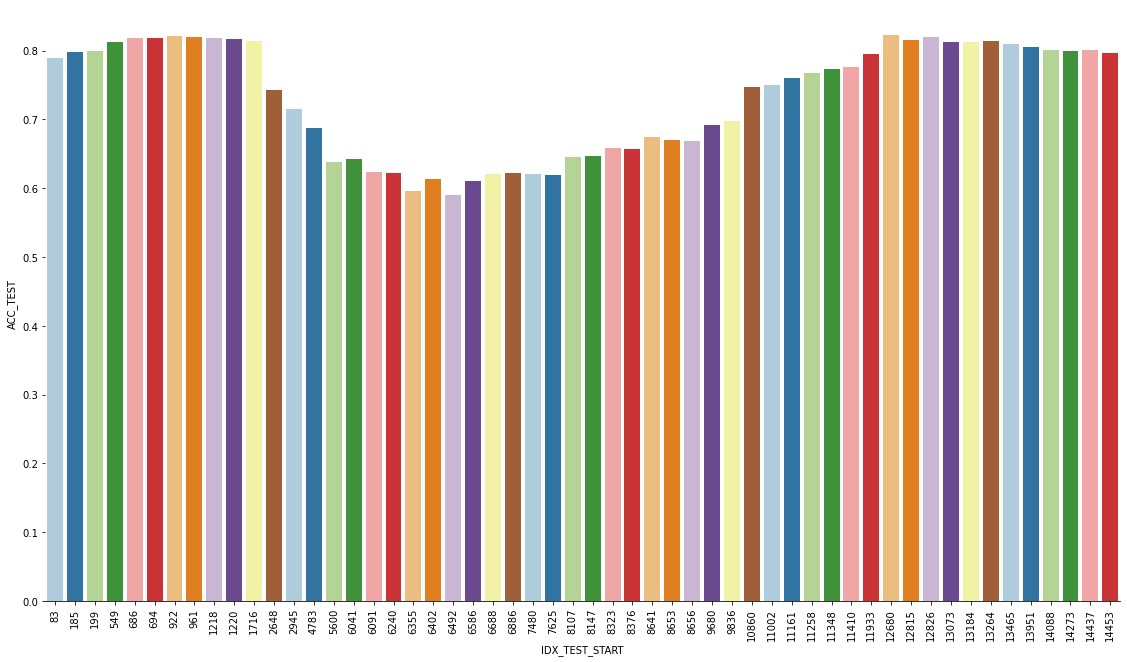

In [25]:


# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="IDX_TEST_START", y="ACC_TEST", #hue="PROFUNDIDAD", #col="LIMITE_DER",
                capsize=.2, palette="Paired", height=5, aspect=.9,
                kind="bar", data=winners)
g.set_xticklabels(rotation=90)
g.fig.set_figwidth(19.27)
g.fig.set_figheight(9.7)
g.despine(left=True)

In [26]:
lost = this_model.loc[this_model['Pred_Return_%'] < 0]
lost['Pred_Return_%'].describe()

count    46.000000
mean    -13.247110
std       8.935954
min     -38.992932
25%     -19.704083
50%     -13.013665
75%      -5.094665
max      -0.030881
Name: Pred_Return_%, dtype: float64